In [4]:
import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

sustain_output_root = "/home/rtandon32/ebm/s-SuStain-outputs/simulation_experiments/complex/output_runtime/"

def get_sustain_results_path(n_samples, n_dims, nc, rep, SuStaIn_type, root_path=sustain_output_root):
    path = os.path.join(root_path, 
                 "{}_samples".format(n_samples),
                 "{}_dims".format(n_dims),
                 "{}_components".format(4),
                 "SuStaIn_{}".format(SuStaIn_type),
                 "simulation_rep_{}".format(rep),
                 "pickle_files",
                 "simulation_rep_{}_subtype{}.pickle".format(rep, nc))
    return path

def read_sustain_results(path):
    if os.path.exists(path):
        with open(path, "rb") as input_file:
            pkl = pickle.load(input_file)
    else:
        pkl = None
    return pkl
    
def get_run_times(n_s, n_d, n_c, r, s_t):
    path = get_sustain_results_path(n_s, n_d, n_c, r, s_t)
    pkl = read_sustain_results(path)
    if pkl is not None:
        run_times = pkl["run_times"]
    else:
        run_times = [None, None]
    return run_times
    

In [17]:
n_samples = [200]
n_dims = [50, 100,150, 200]
n_comps = 4
reps = list(range(3))
sustain_types = ["classic", "sEBM"]
exp_results = []
for n_s in n_samples:
    for n_d in n_dims:
        for n_c in range(1,n_comps):
            for r in reps:
                for s_t in sustain_types:
                    obs = [n_s, n_d, n_c, r, s_t]
                    run_times = get_run_times(n_s, n_d, n_c, r, s_t)
                    row = np.hstack([obs, run_times])
                    exp_results.append(row)

cols = ["N_samples", "N_dim", "N_components", "seed", "sustain-type", "opt-time", "mcmc-time"]
exp_results_df = pd.DataFrame(np.vstack(exp_results), columns=cols)
col_diff = exp_results_df.columns.difference(["sustain-type"])
exp_results_df[col_diff] = exp_results_df[col_diff].astype("float")
x = exp_results_df


df_list = []
for s_t in sustain_types:
    for n_d in n_dims:
        for r in reps:
            mini_df = x[(x["sustain-type"].isin([s_t])) & (x["N_dim"].isin([n_d])) & (x["seed"]==r)]
            mini_df.sort_values("N_components", inplace=True)
            mini_df["opt-time"] = mini_df["opt-time"].cumsum()
            df_list.append(mini_df)

y = pd.concat(df_list, axis=0)

<ipython-input-17-67743ae7704b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df.sort_values("N_components", inplace=True)
<ipython-input-17-67743ae7704b>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["opt-time"] = mini_df["opt-time"].cumsum()


In [9]:
y["opt-time"] = np.log10(y["opt-time"])

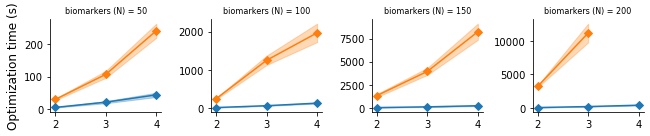

In [18]:
gb_mean = y.groupby(["sustain-type", "N_dim", "N_components"]).mean()["opt-time"]
gb_sem = y.groupby(["sustain-type", "N_dim", "N_components"]).sem()["opt-time"]

fig, ax  = plt.subplots(1,4,sharex=True, figsize=(9.14,2))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
clr_dict = dict(zip(sustain_types, colors[:2][::-1]))
for idx, n_d in enumerate(n_dims):
    for s_t in sustain_types:
        mean_time = gb_mean[s_t][n_d]
        sem_time = gb_sem[s_t][n_d]
        ax[idx].plot(np.array(mean_time.index.tolist())+1, mean_time, marker="D", ms=6, c=clr_dict[s_t])
        ax[idx].fill_between(np.array(mean_time.index.tolist())+1, mean_time + sem_time, 
                             mean_time - sem_time, alpha=0.3, color=clr_dict[s_t])
        ax[idx].set_title("biomarkers (N) = {}".format(int(n_d)), fontsize=8)
        ax[idx].set_xticks(np.array(mean_time.index.tolist())+1)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)

ax[0].set_ylabel("Optimization time (s)", fontsize=12)
# fig.supxlabel("sub-types (T)")

fig.tight_layout()
fig.savefig("/home/rtandon32/ebm/s-SuStain-outputs/data_dump/figures/run_time.png", transparent=True, dpi=300)

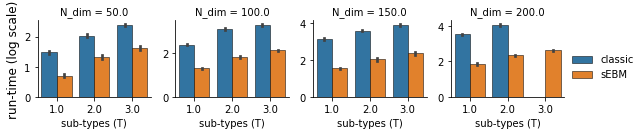

In [12]:
run_time = sns.catplot(y, sharey=False, kind="bar", x="N_components", y="opt-time", col="N_dim", hue="sustain-type", errorbar="se", height=2, aspect=1, linewidth=0.5, edgecolor="k", legend_out=True)
run_time.set_ylabels(r"run-time (log scale)",fontsize=12)
run_time.set_xlabels("sub-types (T)",fontsize=10)
run_time._legend.set_title(None)
run_time.figure.savefig("/home/rtandon32/ebm/s-SuStain-outputs/data_dump/figures/run_time.png", dpi=300, transparent=True)

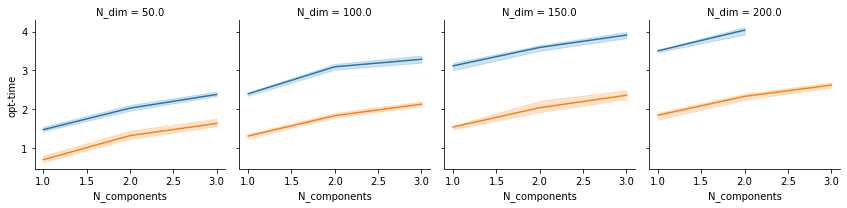

In [15]:
g = sns.FacetGrid(y, col="N_dim")
g.map_dataframe(sns.lineplot, x="N_components", y="opt-time", hue="sustain-type")
g.figure.savefig("/home/rtandon32/ebm/s-SuStain-outputs/data_dump/figures/run_time.png", dpi=300, transparent=True)